In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import time


In [2]:
train_df = pd.read_csv("option_train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   1680 non-null   float64
 1   S       1680 non-null   float64
 2   K       1680 non-null   int64  
 3   tau     1680 non-null   float64
 4   r       1680 non-null   float64
 5   BS      1680 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 78.9+ KB


## Preprocessing

In [3]:
train_df.head()

,Value,S,K,tau,r,BS
0,21.670404,431.623898,420,0.341270,0.03013,Under
1,0.125000,427.015526,465,0.166667,0.03126,Over
2,20.691244,427.762336,415,0.265873,0.03116,Under
3,1.035002,451.711658,460,0.063492,0.02972,Over
4,39.553020,446.718974,410,0.166667,0.02962,Under


In [4]:
train_df.BS = train_df.BS.replace({'Under':0, 'Over':1})
train_df = train_df.drop(columns = ['Value']) 
# assume we can't use Value so we drop it

X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]

In [5]:
# classfication error: all wrong points /total number 

## Creating variables & MinMaxScale

#### Anushka's procress

In [6]:
# define function 
# multiplying all fields 

def create_variables(df):
    cols = list(df.columns)
    name = ''
    name2 = ''
    result = pd.Series(1, index=range(X.shape[0]))
    for i in cols:
        name = name + str(i) + "*"
        name2 = name2 + str(i) + "/"
        #result = result*X[i]
    #df[name] = result


    for i in cols:
        cols.remove(i)
        for ii in cols:
            if i != ii:
                name = str(i)+"*"+str(ii)
                name2 = str(i)+"/"+str(ii)
                df[name] = df[i]*df[ii]
                df[name2] = df[i]/df[ii]
        for iii in cols:
            #print(f'i:{i}, ii:{ii}, iii:{iii}')
            if i != iii and ii != iii and i != ii:
                #print(f'i:{i}, ii:{ii}, iii:{iii}')
                name = str(i)+"*"+str(ii)+"*"+str(iii)
                df[name] = df[i]*df[ii]*df[iii]

    return df

create_variables(X)

,S,K,tau,r,S*K,S/K,S*tau,S/tau,S*r,S/r,S*r*K,S*r*tau,tau*K,tau/K,tau*r,tau/r,tau*r*K
0,431.623898,420,0.341270,0.03013,181282.037286,1.027676,147.300219,1264.758401,13.004828,14325.386601,5462.027783,4.438156,143.333333,0.000813,0.010282,11.326580,4.318633
1,427.015526,465,0.166667,0.03126,198562.219543,0.918313,71.169254,2562.093150,13.348505,13660.125589,6207.054983,2.224751,77.500000,0.000358,0.005210,5.331627,2.422650
2,427.762336,415,0.265873,0.03116,177521.369606,1.030753,113.730463,1608.897145,13.329074,13727.931207,5531.565877,3.543841,110.337302,0.000641,0.008285,8.532510,3.438110
3,451.711658,460,0.063492,0.02972,207787.362588,0.981982,28.680105,7114.458665,13.424870,15198.911770,6175.440416,0.852373,29.206349,0.000138,0.001887,2.136341,0.868013
4,446.718974,410,0.166667,0.02962,183154.779504,1.089558,74.453163,2680.313841,13.231816,15081.666928,5425.044569,2.205303,68.333333,0.000407,0.004937,5.626829,2.024033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675,444.397163,475,0.273810,0.03034,211088.652662,0.935573,121.680176,1623.015726,13.483010,14647.236767,6404.429722,3.691777,130.059524,0.000576,0.008307,9.024704,3.946006
1676,438.453825,410,0.301587,0.02972,179766.068250,1.069400,132.232106,1453.820576,13.030848,14752.820491,5342.647548,3.929938,123.650794,0.000736,0.008963,10.147621,3.674902
1677,428.042219,390,0.170635,0.03188,166936.465410,1.097544,73.038950,2508.526487,13.645986,13426.669354,5321.934517,2.328482,66.547619,0.000438,0.005440,5.352413,2.121538
1678,439.081203,480,0.293651,0.02962,210758.977248,0.914753,128.936544,1495.249499,13.005585,14823.808325,6242.680906,3.819100,140.952381,0.000612,0.008698,9.913936,4.175010


In [7]:
X['K-S'] = X.K - X.S

cols = X.columns
X = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X, columns = cols )
X.head()

,S,K,tau,r,S*K,S/K,S*tau,S/tau,S*r,S/r,S*r*K,S*r*tau,tau*K,tau/K,tau*r,tau/r,tau*r*K,K-S
0,0.202299,0.36,0.867347,0.261603,0.336600,0.527326,0.829308,0.001031,0.243026,0.498204,0.280827,0.820816,0.749947,0.836173,0.858454,0.876363,0.742367,0.403330
1,0.050749,0.72,0.418367,0.738397,0.604273,0.102610,0.395640,0.012539,0.516604,0.153673,0.686948,0.406738,0.401345,0.363717,0.430090,0.407063,0.412605,0.854009
2,0.075309,0.32,0.673469,0.696203,0.278347,0.539275,0.638083,0.004083,0.501137,0.188789,0.318733,0.653510,0.575226,0.657345,0.689737,0.657636,0.589221,0.392988
3,0.862901,0.68,0.153061,0.088608,0.747172,0.349871,0.153608,0.052920,0.577393,0.950592,0.669715,0.149997,0.145619,0.134424,0.149465,0.156928,0.142213,0.584228
4,0.698712,0.28,0.418367,0.046414,0.365609,0.767650,0.414346,0.013587,0.423716,0.889872,0.260667,0.403100,0.352805,0.413739,0.407007,0.430172,0.343275,0.175348


In [8]:
X_copy = X
X_origin = X.iloc[:,0:4]

In [9]:
X.shape

(1680, 18)

## Feature Selection
- backward wrapper with logistics model 

In [10]:

def backward_wrapper(x, y, method, estimator):
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.feature_selection import RFECV
    
    if estimator == 'logreg':
        model = LogisticRegression(penalty='l2', class_weight='balanced')
        #model = LogisticRegression()
    elif estimator == 'dt':
        model = DecisionTreeClassifier()

    if method == 'rfecv':
    
        rfecv = RFECV(estimator=model, step=1, cv=2, verbose=2, n_jobs=1, scoring="accuracy")
        rfecv.fit(x, y)
        
        print(rfecv.ranking_)

        tops = pd.DataFrame()
        tops['var'] = x.columns;tops['rank'] = rfecv.ranking_
        tops = tops[tops['rank'] == 1]
        # #if estimator == 'dt':
        # tops = tops.sort_values('rank').reset_index(inplace = False)
        # tops = tops.iloc[:n,:]

        
        plt.figure()
        plt.xlabel("Number of Feature Selected")
        plt.ylabel("Cross Validation Score")
        plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
        plt.show()
    
    elif method == 'rfe':
        rfe = RFE(model)
        rfe.fit(x,y)
        tops = pd.DataFrame()
        tops['var'] = x.columns;tops['rank'] = rfe.ranking_
        tops = tops[tops['rank'] == 1]

    return tops 

In [11]:
# using REF

# model = LogisticRegression(max_iter=1700, penalty='none')
# rfe = RFE(model, n_features_to_select=20)
# rfe.fit(X,y)

# var_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfe.ranking_), X.columns)),
#                            columns = ['ranking','var'])
# print(var_selected)

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fi

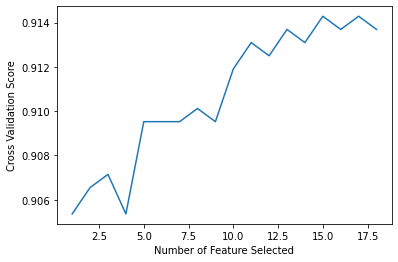

In [12]:
select = backward_wrapper(
    x = X,
    y = y,
    method='rfecv',
    estimator = 'logreg'
)

In [13]:
#select = var_selected

In [14]:
# Select top ranking variales as X
X = X.loc[:, list(select['var'])]
X.head()

,S,K,r,S*K,S/K,S*tau,S/tau,S*r,S/r,S*r*K,S*r*tau,tau*K,tau/K,tau*r*K,K-S
0,0.202299,0.36,0.261603,0.336600,0.527326,0.829308,0.001031,0.243026,0.498204,0.280827,0.820816,0.749947,0.836173,0.742367,0.403330
1,0.050749,0.72,0.738397,0.604273,0.102610,0.395640,0.012539,0.516604,0.153673,0.686948,0.406738,0.401345,0.363717,0.412605,0.854009
2,0.075309,0.32,0.696203,0.278347,0.539275,0.638083,0.004083,0.501137,0.188789,0.318733,0.653510,0.575226,0.657345,0.589221,0.392988
3,0.862901,0.68,0.088608,0.747172,0.349871,0.153608,0.052920,0.577393,0.950592,0.669715,0.149997,0.145619,0.134424,0.142213,0.584228
4,0.698712,0.28,0.046414,0.365609,0.767650,0.414346,0.013587,0.423716,0.889872,0.260667,0.403100,0.352805,0.413739,0.343275,0.175348


## Model Training
- Log Reg
- DT
- XGboost
- RF

Goodness will be measured by classification error rate *e*:

$$ e = \dfrac{FP+FN}{TP+TN+FP+FP} $$

In [15]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True)

## log reg

In [16]:
%%time
kf = KFold(n_splits = 10, shuffle = True)

table = pd.DataFrame(columns=['penalty', 'solver','X_set', 'Error'])

x_dict = {
    'X': X,
    'X_copy': X_copy,
    'X_origin': X_origin
}

# log reg

row_index = 0
for i in ['l1', 'l2']:
    for ii in ['liblinear','saga']:
        for x in ['X', 'X_copy', 'X_origin']:
            table.loc[row_index, 'penalty'] = i
            table.loc[row_index, 'solver'] = ii
            table.loc[row_index, 'X_set'] = x

            model = LogisticRegression(penalty=i,solver=ii)

            e = round(1-cross_val_score(model, x_dict[x], y, scoring='accuracy', cv=kf).mean(), 4)
            table.loc[row_index, 'Error'] = e
            print(f'Row {row_index} calculation finished.')
            row_index += 1

table.sort_values("Error", ascending=True)

Row 0 calculation finished.
Row 1 calculation finished.
Row 2 calculation finished.
Row 3 calculation finished.
Row 4 calculation finished.
Row 5 calculation finished.
Row 6 calculation finished.
Row 7 calculation finished.
Row 8 calculation finished.
Row 9 calculation finished.
Row 10 calculation finished.
Row 11 calculation finished.
CPU times: user 2.74 s, sys: 20.8 ms, total: 2.76 s
Wall time: 2.77 s


,penalty,solver,X_set,Error
9,l2,saga,X,0.0827
10,l2,saga,X_copy,0.0833
7,l2,liblinear,X_copy,0.0839
0,l1,liblinear,X,0.0851
4,l1,saga,X_copy,0.0851
6,l2,liblinear,X,0.0851
1,l1,liblinear,X_copy,0.0857
5,l1,saga,X_origin,0.0857
8,l2,liblinear,X_origin,0.0857
2,l1,liblinear,X_origin,0.0869


In [17]:
# DT

## XGboost

In [18]:
# %%time
# kf = KFold(n_splits = 10, shuffle = True)

# table = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'max_depth','X_set', 'Error'])

# x_dict = {
#     'X': X,
#     'X_copy': X_copy,
#     'X_origin': X_origin
# }

# # XGB

# row_index = 0
# for i in range(400, 700, 100):
#     for ii in [0.01,0.1]:
#         for iii in [3, 5]:
#             for x in ['X', 'X_copy', 'X_origin']:
#                 table.loc[row_index, 'n_estimators'] = i
#                 table.loc[row_index, 'learning_rate'] = ii
#                 table.loc[row_index, 'max_depth'] = iii
#                 table.loc[row_index, 'X_set'] = x

#                 model = GradientBoostingClassifier(
#                                         n_estimators=i, 
#                                         learning_rate=ii,
#                                         max_depth=iii)

#                 e = round(1-cross_val_score(model, x_dict[x], y, scoring='accuracy', cv=kf).mean(), 4)
#                 table.loc[row_index, 'Error'] = e
#                 print(f'Row {row_index} calculation finished.')
#                 row_index += 1

# table.sort_values("Error", ascending=True)

## rf

In [19]:
%%time
kf = KFold(n_splits = 10, shuffle = True)

rf_table = pd.DataFrame(columns=['n_estimators', 'max_depth', 'X_set', 'Error'])

x_dict = {
    'X': X,
    'X_copy': X_copy,
    'X_origin': X_origin
}

row_index = 0
for i in range(50, 300, 50):
    for ii in [10, 15, 20, 30]:
        for x in ['X', 'X_copy', 'X_origin']:
            rf_table.loc[row_index, 'n_estimators'] = i
            rf_table.loc[row_index, 'max_depth'] = ii
            rf_table.loc[row_index, 'X_set'] = x

            rf = RandomForestClassifier(
                                        n_estimators=i,
                                        max_depth=ii
                                        )
            e = round(1-cross_val_score(rf, x_dict[x], y, scoring='accuracy', cv=kf).mean(), 4)
            rf_table.loc[row_index, 'Error'] = e
            print(f'Row {row_index} calculation finished.')
            row_index += 1
            

rf_table.sort_values("Error", ascending=True)
            


Row 0 calculation finished.
Row 1 calculation finished.
Row 2 calculation finished.
Row 3 calculation finished.
Row 4 calculation finished.
Row 5 calculation finished.
Row 6 calculation finished.
Row 7 calculation finished.
Row 8 calculation finished.
Row 9 calculation finished.
Row 10 calculation finished.
Row 11 calculation finished.
Row 12 calculation finished.
Row 13 calculation finished.
Row 14 calculation finished.
Row 15 calculation finished.
Row 16 calculation finished.
Row 17 calculation finished.
Row 18 calculation finished.
Row 19 calculation finished.
Row 20 calculation finished.
Row 21 calculation finished.
Row 22 calculation finished.
Row 23 calculation finished.
Row 24 calculation finished.
Row 25 calculation finished.
Row 26 calculation finished.
Row 27 calculation finished.
Row 28 calculation finished.
Row 29 calculation finished.
Row 30 calculation finished.
Row 31 calculation finished.
Row 32 calculation finished.
Row 33 calculation finished.
Row 34 calculation finis

,n_estimators,max_depth,X_set,Error
48,250,10,X,0.0589
16,100,15,X_copy,0.0601
57,250,30,X,0.0607
22,100,30,X_copy,0.0607
46,200,30,X_copy,0.0631
39,200,15,X,0.0631
35,150,30,X_origin,0.0637
27,150,15,X,0.0637
24,150,10,X,0.0637
34,150,30,X_copy,0.0637


In [24]:
# use best model to create prediction 

n = 250
max_depth = 10

# retrain the model with all 
train_df = pd.read_csv("option_train.csv")
train_df.BS = train_df.BS.replace({'Under':0, 'Over':1})
train_df = train_df.drop(columns = ['Value']) 
X = train_df.iloc[:, :-1]
y = train_df.iloc[:, -1]



In [25]:
def create_variables(df):
    cols = list(df.columns)
    name = ''
    name2 = ''
    result = pd.Series(1, index=range(X.shape[0]))
    for i in cols:
        name = name + str(i) + "*"
        name2 = name2 + str(i) + "/"
        #result = result*X[i]
    #df[name] = result


    for i in cols:
        cols.remove(i)
        for ii in cols:
            if i != ii:
                name = str(i)+"*"+str(ii)
                name2 = str(i)+"/"+str(ii)
                df[name] = df[i]*df[ii]
                df[name2] = df[i]/df[ii]
        for iii in cols:
            #print(f'i:{i}, ii:{ii}, iii:{iii}')
            if i != iii and ii != iii and i != ii:
                #print(f'i:{i}, ii:{ii}, iii:{iii}')
                name = str(i)+"*"+str(ii)+"*"+str(iii)
                df[name] = df[i]*df[ii]*df[iii]

    return df

create_variables(X)

X['K-S'] = X.K - X.S

cols = X.columns
X = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X, columns = cols)

X = X.loc[:, list(select['var'])]
X.head()


,S,K,r,S*K,S/K,S*tau,S/tau,S*r,S/r,S*r*K,S*r*tau,tau*K,tau/K,tau*r*K,K-S
0,0.202299,0.36,0.261603,0.336600,0.527326,0.829308,0.001031,0.243026,0.498204,0.280827,0.820816,0.749947,0.836173,0.742367,0.403330
1,0.050749,0.72,0.738397,0.604273,0.102610,0.395640,0.012539,0.516604,0.153673,0.686948,0.406738,0.401345,0.363717,0.412605,0.854009
2,0.075309,0.32,0.696203,0.278347,0.539275,0.638083,0.004083,0.501137,0.188789,0.318733,0.653510,0.575226,0.657345,0.589221,0.392988
3,0.862901,0.68,0.088608,0.747172,0.349871,0.153608,0.052920,0.577393,0.950592,0.669715,0.149997,0.145619,0.134424,0.142213,0.584228
4,0.698712,0.28,0.046414,0.365609,0.767650,0.414346,0.013587,0.423716,0.889872,0.260667,0.403100,0.352805,0.413739,0.343275,0.175348


In [28]:
test_df = pd.read_csv("option_test_wolabel.csv")

test_df = create_variables(test_df)

test_df['K-S'] = test_df.K - test_df.S

cols = test_df.columns
test_df = MinMaxScaler().fit_transform(test_df)
test_df = pd.DataFrame(test_df, columns = cols)

test_df = test_df.loc[:, list(select['var'])]
test_df.head()



,S,K,r,S*K,S/K,S*tau,S/tau,S*r,S/r,S*r*K,S*r*tau,tau*K,tau/K,tau*r*K,K-S
0,0.202125,0.68,0.827004,0.613540,0.193724,0.712219,0.002954,0.703299,0.182217,0.740228,0.736727,0.699075,0.661603,0.723103,0.759841
1,0.235494,0.36,0.827004,0.342621,0.536294,0.440091,0.011230,0.728718,0.198915,0.454657,0.455476,0.392950,0.447374,0.406706,0.398503
2,0.235494,0.44,0.827004,0.412229,0.446879,0.440091,0.011230,0.728718,0.198915,0.528029,0.455476,0.402516,0.436747,0.416593,0.486603
3,0.202125,0.32,0.827004,0.301043,0.573492,0.712219,0.002954,0.703299,0.182217,0.410830,0.736727,0.629822,0.734383,0.651527,0.363393
4,0.305855,0.36,0.827004,0.357079,0.555309,0.098342,0.081010,0.782317,0.234125,0.469897,0.102268,0.087241,0.099683,0.090738,0.379654


In [33]:

rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth)
rf.fit(X, y)
predicted = rf.predict(test_df)

predicted=pd.DataFrame(predicted).rename(columns={0:'BS'})


In [34]:
predicted.to_csv('ClassificationPredictions.csv')

In [20]:
# %%time
# kf = KFold(n_splits = 10, shuffle = True)

# table = pd.DataFrame(columns=['hidden_layer_sizes', 'solver', 'max_iter','X_set', 'Error'])

# x_dict = {
#     'X': X,
#     'X_copy': X_copy,
#     'X_origin': X_origin
# }

# # NN

# row_index = 0
# for i in [(100,3),(100,5),(200,3)]:
#     for ii in ['sgd', 'adam']:
#         for iii in [150, 200]:
#             for x in ['X', 'X_copy', 'X_origin']:
#                 table.loc[row_index, 'hidden_layer_sizes'] = str(i)
#                 table.loc[row_index, 'solver'] = ii
#                 table.loc[row_index, 'max_iter'] = iii
#                 table.loc[row_index, 'X_set'] = x

#                 model = MLPClassifier(hidden_layer_sizes = i, solver = ii, random_state=1, max_iter=iii)

#                 e = round(1-cross_val_score(model, x_dict[x], y, scoring='accuracy', cv=kf).mean(), 4)
#                 table.loc[row_index, 'Error'] = e
#                 print(f'Row {row_index} calculation finished.')
#                 row_index += 1

# table.sort_values("Error", ascending=True)

In [21]:
# # define function

# def model_e(X, y, model):
#     '''
#     model: one of 'logreg', 'lda', 'knn' 
#     '''
#     if model == 'logreg':
#         from sklearn.linear_model import LogisticRegression
#         model = LogisticRegression()
#     elif model == 'knn':
#         print("Please choose your n for KNN model:")
#         n = int(input()) # n of your choice
#         print(f"Choose {n}.")
#         from sklearn.neighbors import KNeighborsClassifier
#         model = KNeighborsClassifier(n_neighbors=n)

#     avg_score = 1-cross_val_score(model, X, y, cv=3).mean()
    
    

#     # e_list = []
#     # for i in range(10):
#     #     X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = i)
#     #     model.fit(X_train, y_train)
#     #     e = 1-model.score(X_test, y_test)
#     #     e_list.append(e)

#     # e = sum(e_list)/len(e_list)
#     print(f'Average classification error rate for {model} is {round(avg_score,4)}.')
        

# model_e(X_train, y_train, 'logreg')


